In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
#import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from sklearn import linear_model
import skvideo.io

GPU = True #False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'

num GPUs 1


(105, 180, 180, 1)


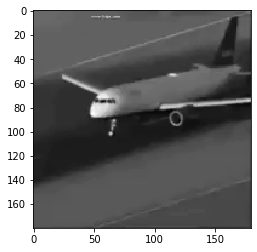

In [27]:
videodata = skvideo.io.vread('LandingPlane_180.mp4', as_grey = True)
#videodata = np.squeeze(videodata)
print(videodata.shape)
plt.imshow(videodata[0,:,:,0])
plt.gray()
videodata = videodata/np.max(videodata)
videodata_org = videodata * 1;

Compression/denoising mode
n_scales= 3 num_channels_up= [25, 15, 10]
number of parameters:  1800
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(25, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(15, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (sig): Sigmoid()
)
shape of latent code B1:  [1, 25, 45, 45]
initializing latent code B1...
not optimizing over latent code Z1
optimize decoder with SGD

KeyboardInterrupt: 

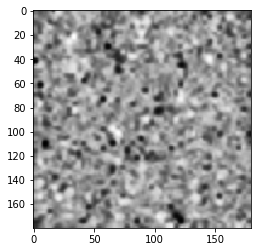

In [47]:
mode = 1;
print('Compression/denoising mode')
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample
num_channels = [25,15,10]

for frame_idx in range(videodata.shape[0]):
    frame_now = videodata[frame_idx,:,:,:].transpose(2,0,1)
    frame_org = frame_now * 1
    #if frame_idx == 0:
    #    plt.imshow(frame_now[0,:,:])
    #print(frame_now.shape)
    frame_var = Variable(torch.from_numpy(frame_now)[None, :]).type(dtype)
    #print(frame_var.shape)
    d = frame_now.shape[1]
    out_ch = frame_now.shape[0]
    d_image = frame_now.size
    # compression/denoising mode
    f = 1
    Ameas_var = 1
    frame_var_meas = frame_var
    output_depth = frame_now.shape[0]
    net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, Ameas=Ameas_var,
                        decodetype=decodetype
                        ).type(dtype)
    if frame_idx ==0:
        print("number of parameters: ", num_param(net))
        if decodetype == 'upsample':
            print(net.decoder)
        elif decodetype == 'transposeconv':
            print(net.convdecoder)
    net_in = copy.deepcopy(net)
    #pick optimization procedure
    optim = 'pgd'             #'pgd' (projected gradient descent), 'gd' (gradient descent)
    if optim == 'pgd':
        optimizer2='SGD'      #outer loop optimizer - 'SGD' (or try 'adam')
        numit = 1000          #number of outer iterations of LS
        LR_LS = 20            #typically 5-10 ; required for outer loop of LS

        OPTIMIZER='SGD'       #inner loop optimizer - SGD or adam
        numit_inner = 10      #number of inner loop iterations for projection
        LR = 0.02             #typically 0.02-0.05 for pgd/inner loop of projection, higher for more complex structures

        lr_decay_epoch = 500  #decay learning rates of both inner and outer optimizers

    elif optim == 'gd':
        OPTIMIZER='SGD'       #optimizer - SGD or adam 
        numit = 5000         #number of iterations for SGD
        LR = 0.08              #typically 0.02-0.5 for gd , higher for more complex structures

        optimizer2 = None                                    
        numit_inner = None
        LR_LS = None

        lr_decay_epoch = 3000
    
    t0 = time.time()
    mse_t, ni, net, ni_mod, in_np_img = fit( 
                                net=net,
                                num_channels=num_channels,
                                num_iter=numit,
                                numit_inner = numit_inner,
                                LR=LR,
                                LR_LS = LR_LS,
                                OPTIMIZER = OPTIMIZER,                          
                                optimizer2 = optimizer2,             
                                lr_decay_epoch = lr_decay_epoch,             
                                img_clean_var=frame_var_meas,
                                find_best=True,
                                Ameas = Ameas_var,
                                model = mode,
                                code='uniform',
                                decodetype=decodetype,
                                optim=optim,
                                out_channels=out_ch        
                                )
    t1 = time.time()
    print('\nframe ',frame_idx, 'time elapsed:',t1-t0)
    
    print('init error')
    lvls = len(num_channels)
    if decodetype == 'upsample':
        nettype = net.decoder
        netintype = net_in.decoder
    elif decodetype == 'transposeconv':
        nettype = net.convdecoder
        netintype = net_in.convdecoder
    ComputeInitErr(nettype,netintype,lvls)
    
    out_frame_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    maxv = np.max(frame_now)
    reconstruction_err = mse(frame_org,out_frame_np,maxv)
    print('frame', frame_idx,'MSE:',reconstruction_err)
    plt.imshow(np.squeeze(out_frame_np))
    
    in_img = in_np_img.data.cpu().numpy()
    reconstruction_err = mse(frame_org,in_img,maxv)
    print('frame', frame_idx,'init MSE:',reconstruction_err)
    plt.imshow(np.squeeze(in_img))